In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("deforestation_cases/training_data.csv")
df.head()

,id,start_year,end_year,min_lat,max_lat,min_lon,max_lon,aoi_area_ha,loss_area_ha,loss_pct,before_mean,after_mean,diff_mean,label
0,sample_20250822_154447,2022,2024,-9.383098,-9.283098,-65.340292,-65.240292,0.0,32.562429,0.0,0.510094,0.499669,-0.010425,0
1,sample_20250822_154516,2022,2024,-5.166588,-5.066588,-54.982566,-54.882566,0.0,4.007258,0.0,0.522228,0.522144,-0.000084,0
2,sample_20250822_154556,2022,2024,-1.213485,-1.113485,-68.972478,-68.872478,0.0,16.544487,0.0,0.499666,0.505169,0.005504,0
3,sample_20250822_154701,2022,2024,-4.159839,-4.059839,-65.367052,-65.267052,0.0,0.356694,0.0,0.496299,0.493365,-0.002934,0
4,sample_20250822_154726,2022,2024,-3.235189,-3.135189,-60.804090,-60.704090,0.0,345.347429,0.0,0.312463,0.315633,0.003170,0


In [21]:

# applying weighted mean difference to account for larger aois
df["diff_weighted"] = df["diff_mean"] * np.log1p(df["aoi_area_ha"])
df["significant_change"] = (
    abs(df["diff_mean"]) > (0.02 * np.log1p(df["aoi_area_ha"]))
).astype(int)
df["diff_area_interaction"] = df["diff_mean"] * df["aoi_area_ha"]

df.columns = df.columns.str.strip()
print(df.info())
print(df.describe())
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533 entries, 0 to 3532
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3533 non-null   object 
 1   start_year             3533 non-null   int64  
 2   end_year               3533 non-null   int64  
 3   min_lat                3533 non-null   float64
 4   max_lat                3533 non-null   float64
 5   min_lon                3533 non-null   float64
 6   max_lon                3533 non-null   float64
 7   aoi_area_ha            3533 non-null   float64
 8   loss_area_ha           3533 non-null   float64
 9   loss_pct               3533 non-null   float64
 10  before_mean            3533 non-null   float64
 11  after_mean             3533 non-null   float64
 12  diff_mean              3533 non-null   float64
 13  label                  3533 non-null   int64  
 14  diff_weighted          3533 non-null   float64
 15  sign

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

features = [
    "aoi_area_ha",
    "loss_area_ha",
    "loss_pct",
    "before_mean",
    "after_mean",
    "diff_mean",
    "diff_weighted",
    "diff_area_interaction"
]

X = df[features]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
clf.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[664   1]
 [  1  41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       0.98      0.98      0.98        42

    accuracy                           1.00       707
   macro avg       0.99      0.99      0.99       707
weighted avg       1.00      1.00      1.00       707



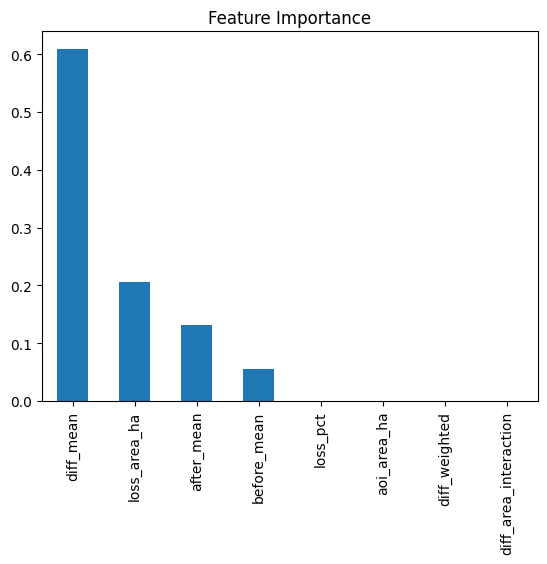

In [24]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind="bar", title="Feature Importance")
plt.show()

In [27]:
# Base input
new_aoi = pd.DataFrame([{
    "aoi_area_ha": 0.0,
    "loss_area_ha": 50.0,
    "loss_pct": 0.0,
    "before_mean": 0.48,
    "after_mean": 0.2,
    "diff_mean": -0.28
}])

# Add engineered features (must match training)
new_aoi["diff_weighted"] = new_aoi["diff_mean"] * np.log1p(new_aoi["aoi_area_ha"])
new_aoi["diff_area_interaction"] = new_aoi["diff_mean"] * new_aoi["aoi_area_ha"]

# (add more engineered features here if you used them during training,
#  e.g., aoi_area_log1p, diff_significant, etc.)

# Reorder to match training features
new_aoi = new_aoi[X.columns]   # X was your training features DataFrame

# Scale & predict
new_aoi_scaled = scaler.transform(new_aoi)
prediction = clf.predict(new_aoi_scaled)

print("Deforestation" if prediction[0] == 1 else "Not Deforestation")


Deforestation


In [29]:
import joblib

# Save model and scaler
joblib.dump(clf, "deforestation_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model Created!")

Model Created!
